# NBA Playoff Predictor - Feature Engineering

This notebook creates features for predicting NBA playoff outcomes using historical data. It generates factors that represent different parts of team performance, player makeup, and injury patterns that could affect a team's chances of making the playoffs.

## Data Sources

1. **Team Statistics** (`team_stats.csv`):
   - Includes team performance metrics per season, such as scoring, rebounding, assists, and defense.
   - Contains information about playoff qualification (target variable).

2. **Player Statistics** (`player_season.csv`):
   - Contains individual player data per season, including experience and age.
   - Helps analyze the team’s composition.

3. **Injury Summary** (`injuries_summary.csv`):
   - Provides team-level injury counts by year.
   - Used to assess how injuries impact team performance.


In [27]:
# Data manipulation
import pandas as pd
import numpy as np

# System utilities
import sys
from pathlib import Path
import json
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Add the src directory to the path
sys.path.append('..')
from src.features.feature_builder import FeatureBuilder
from src.data.utils import setup_logging

logger = setup_logging()

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## Load and Explore Data

In this section, we load and preview the datasets used for our analysis. Each dataset offers valuable insights that will contribute to the feature engineering process:

### 1. Team Statistics (`team_stats.csv`)
This dataset includes season-level performance data for each team, such as:
- **Performance Metrics**: Points per game, field goal percentage, assists, and rebounds.
- **Playoff Qualification**: A binary target variable, `playoffs`, indicating if a team made the playoffs in a given season.

### 2. Player Statistics (`player_season.csv`)
This dataset contains player-level data for each season, offering:
- **Demographics**: Player age and experience.
- **Team Composition**: Information about roster depth and the distribution of experience across players.

### 3. Injury Summary (`injuries_summary.csv`)
This dataset provides aggregated team-level injury counts by season, allowing:
- **Injury Impact Analysis**: Insights into how injuries affect team performance and playoff chances.
- **Roster Stability**: Evaluation of player availability across seasons.

Each dataset will be explored briefly to ensure we understand its structure and content.



In [28]:
# Load all data sources
data_dir = '../data/processed'

# Load Team Statistics
print("Loading Team Statistics...")
team_stats = pd.read_csv(f'{data_dir}/team_stats.csv')
print(f"Team Stats Shape: {team_stats.shape}")
display(team_stats[['season', 'team', 'playoffs', 'pts_per_game', 'fg_percent']].head())

# Load Player Statistics
print("\nLoading Player Statistics...")
player_stats = pd.read_csv(f'{data_dir}/player_season.csv')
print(f"Player Stats Shape: {player_stats.shape}")
display(player_stats[['season', 'player', 'team', 'age', 'experience']].head())

# Load Injury Summary
print("\nLoading Injury Summary...")
injuries = pd.read_csv(f'{data_dir}/injuries_summary.csv')
print(f"Injuries Shape: {injuries.shape}")
display(injuries.head())

# Summarize datasets
print("\nTeam Statistics Summary:")
print(team_stats.info())

print("\nPlayer Statistics Summary:")
print(player_stats.info())

print("\nInjury Summary Summary:")
print(injuries.info())


Loading Team Statistics...
Team Stats Shape: (659, 29)


,season,team,playoffs,pts_per_game,fg_percent
0,2025,ATL,False,116.1,0.463
1,2025,BOS,False,121.2,0.464
2,2025,BKN,False,111.8,0.468
3,2025,CHI,False,118.5,0.475
4,2025,CHA,False,107.5,0.424



Loading Player Statistics...
Player Stats Shape: (12281, 6)


,season,player,team,age,experience
0,2004,Aaron McKie,PHI,31,10
1,2004,Aaron Williams,BKN,32,10
2,2004,Adonal Foyle,GSW,28,7
3,2004,Adrian Griffin,HOU,29,5
4,2004,Al Harrington,IND,23,6



Loading Injury Summary...
Injuries Shape: (591, 4)


,year,team,count,conference
0,2004,ATL,20,EAST
1,2004,BKN,21,EAST
2,2004,BOS,16,EAST
3,2004,CHA,36,EAST
4,2004,CHI,25,EAST



Team Statistics Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659 entries, 0 to 658
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   season         659 non-null    int64  
 1   lg             659 non-null    object 
 2   team           659 non-null    object 
 3   abbreviation   659 non-null    object 
 4   playoffs       659 non-null    bool   
 5   g              659 non-null    float64
 6   mp_per_game    659 non-null    float64
 7   fg_per_game    659 non-null    float64
 8   fga_per_game   659 non-null    float64
 9   fg_percent     659 non-null    float64
 10  x3p_per_game   659 non-null    float64
 11  x3pa_per_game  659 non-null    float64
 12  x3p_percent    659 non-null    float64
 13  x2p_per_game   659 non-null    float64
 14  x2pa_per_game  659 non-null    float64
 15  x2p_percent    659 non-null    float64
 16  ft_per_game    659 non-null    float64
 17  fta_per_game   659 non-null 

## Create Team Features

To improve our predictions, we create team-level features using the `team_stats` dataset. These features capture important aspects of team performance, grouped into the following categories:

### Efficiency Metrics
These metrics evaluate a team's shooting and rebounding efficiency:
- **True Shooting Percentage (TS%)**: Measures overall scoring efficiency, accounting for free throws and three-pointers.
- **Effective Field Goal Percentage (eFG%)**: Adjusts for the extra value of three-point shots.
- **Offensive Rebound Percentage (OREB%)**: Indicates how well a team secures offensive rebounds.

### Ball Movement and Control
These metrics assess the quality of a team's ball movement and possession management:
- **Assist-to-Turnover Ratio (AST/TO)**: Shows the efficiency of passing relative to turnovers.
- **Assist Ratio (AST%)**: The percentage of field goals assisted by teammates.

### Defensive Impact
These metrics reflect defensive effectiveness:
- **Stocks per Game**: The total number of steals and blocks per game.
- **Defensive Rating**: A comprehensive measure of a team's defensive performance.

### Possession and Pace
Metrics related to the speed and efficiency of play:
- **Possessions per Game**: Estimates the team's pace of play.
- **Offensive Efficiency (OffEff)**: Points scored per possession.
- **Three Point Rate (3P%)**: Shows how often a team relies on three-point shots.
- **Free Throw Rate (FTR)**: Evaluates a team's ability to draw fouls and get to the free throw line.

### Sample and Summary
Below, we display a subset of the engineered features along with their summary statistics to better understand their distributions.


Creating team performance features...
Created 41 team features for 659 seasons.

Sample of engineered team features:


,team,season,true_shooting_pct,efg_pct,ast_to_ratio,stocks_per_game,off_efficiency,efficiency_rating
0,ATL,2025,0.568538,0.531694,1.817073,15.5,1.093179,4.465165
1,BOS,2025,0.604260,0.569214,2.232759,12.6,1.190710,4.129762
2,BKN,2025,0.598399,0.563095,1.808219,10.1,1.123437,2.581872
3,CHI,2025,0.594617,0.564978,1.863636,11.6,1.116408,3.068755
4,CHA,2025,0.543368,0.513187,1.413580,13.3,1.056823,3.523508



Summary statistics for key features:


,count,mean,std,min,25%,50%,75%,max
true_shooting_pct,659.0,0.548909,0.024707,0.483505,0.531726,0.546511,0.566625,0.623650
efg_pct,659.0,0.509504,0.027871,0.438903,0.488742,0.506208,0.530032,0.596413
ast_to_ratio,659.0,1.604520,0.231319,1.011299,1.435099,1.583333,1.755590,2.387597
stocks_per_game,659.0,12.445827,1.266134,8.900000,11.600000,12.400000,13.250000,18.600000
off_efficiency,659.0,1.058324,0.046578,0.923881,1.024216,1.053412,1.090511,1.202537
efficiency_rating,659.0,3.499821,0.534022,1.918881,3.142246,3.490173,3.841921,6.419514


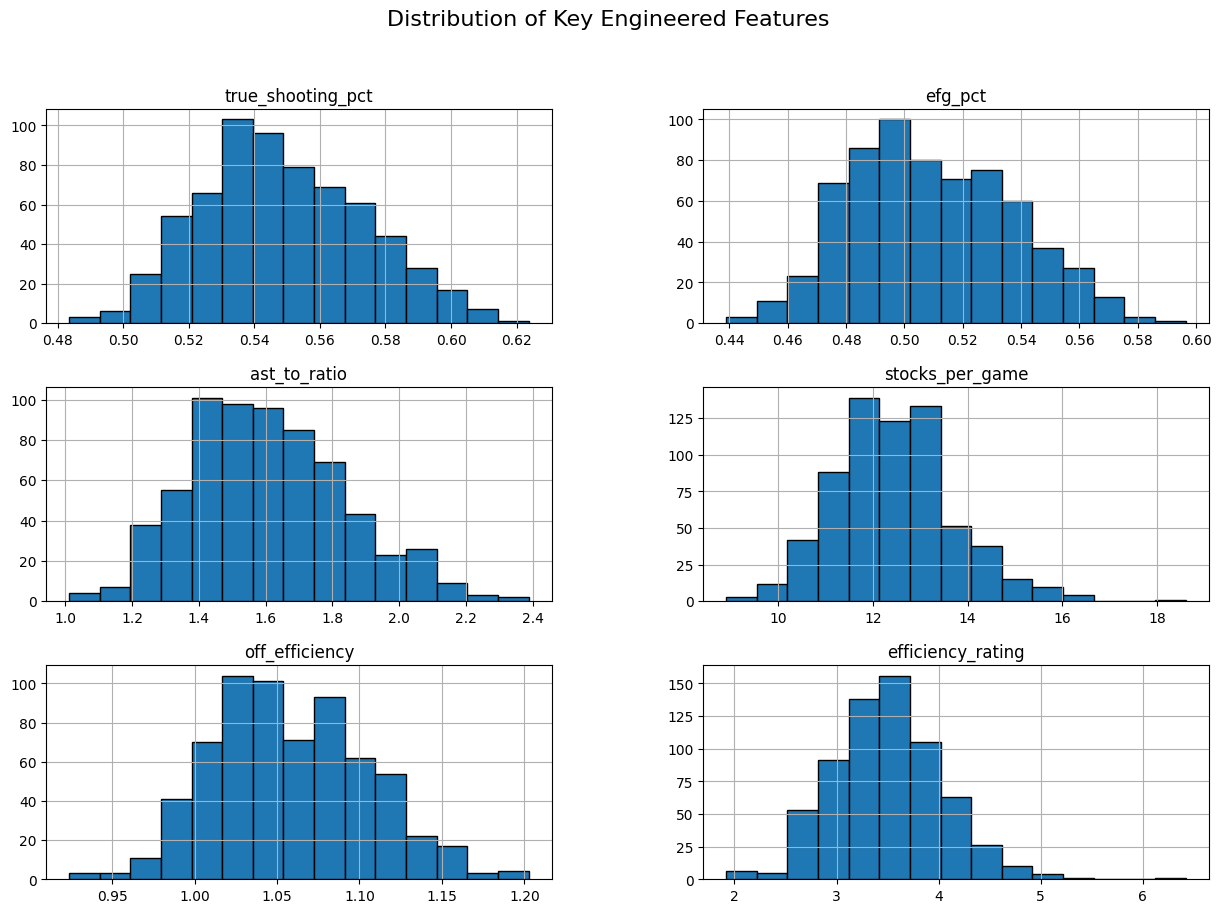

In [29]:
# Create team features
print("Creating team performance features...")
team_features = FeatureBuilder().create_team_features(team_stats)

# Display progress and sample
print(f"Created {len(team_features.columns)} team features for {len(team_features)} seasons.")
print("\nSample of engineered team features:")
feature_sample = [
    'true_shooting_pct', 'efg_pct', 'ast_to_ratio',
    'stocks_per_game', 'off_efficiency', 'efficiency_rating'
]
display(team_features[['team', 'season'] + feature_sample].head())

# Display summary statistics for selected features
print("\nSummary statistics for key features:")
display(team_features[feature_sample].describe().transpose())

# Visualize feature distributions (optional)
team_features[feature_sample].hist(bins=15, figsize=(15, 10), edgecolor='black')
plt.suptitle("Distribution of Key Engineered Features", fontsize=16)
plt.show()


## Create Player Features

This section focuses on creating features based on player statistics and injury data. These features provide insights into team composition and overall health, which are key factors in predicting a team's success.

### Experience and Age
We calculate metrics that capture the experience and age distribution of the team's roster:
- **Experience Metrics**: The average, maximum, and minimum years of experience for the team.
- **Age Demographics**: Includes the average, oldest, and youngest player ages.
- **Roster Size**: The total number of players on the team in a given season.

### Health Impact
Injury data is used to evaluate the impact of player availability:
- **Injury Count**: The total number of injuries affecting the team in a season.
- This metric helps assess the stability and depth of the roster.

### Sample and Summary
Below, we show a sample of the engineered features, followed by summary statistics and distributions. These metrics provide a clear picture of the team's composition and health.



Creating player composition and injury features...
Created 11 player/injury features for 659 seasons.

Sample of engineered player features:


,team,season,avg_experience,roster_size,avg_age,max_age,min_age,count
0,ATL,2004,5.043478,23,26.695652,32,21,20.0
1,ATL,2005,6.750000,20,28.000000,42,19,37.0
2,ATL,2006,3.533333,15,24.133333,32,19,32.0
3,ATL,2007,4.000000,19,24.631579,32,20,78.0
4,ATL,2008,4.875000,16,25.125000,33,21,39.0



Summary statistics for key features:


,count,mean,std,min,25%,50%,75%,max
avg_experience,659.0,5.565131,1.233115,2.652174,4.684211,5.388889,6.312500,9.647059
roster_size,659.0,18.635812,3.199685,12.000000,16.000000,18.000000,20.500000,33.000000
avg_age,659.0,26.403731,1.330941,23.263158,25.500000,26.230769,27.303309,31.315789
max_age,659.0,34.705615,2.648877,26.000000,33.000000,35.000000,36.500000,44.000000
min_age,659.0,20.356601,1.090996,18.000000,20.000000,20.000000,21.000000,24.000000
count,659.0,47.570561,31.148909,0.000000,25.000000,45.000000,65.000000,172.000000


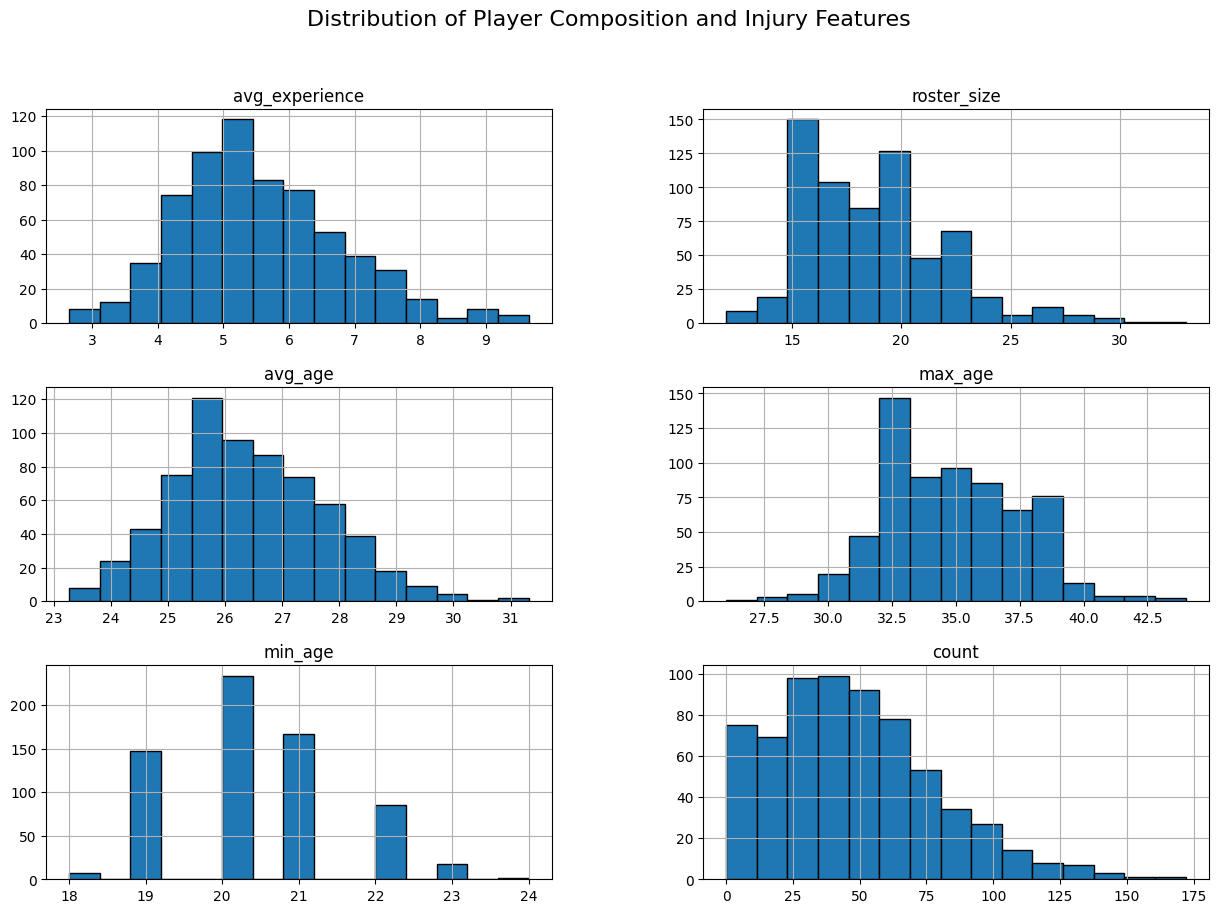

In [30]:
# Create player and injury features
print("Creating player composition and injury features...")
player_features = FeatureBuilder().create_player_features(player_stats, injuries)

# Display progress and sample
print(f"Created {len(player_features.columns)} player/injury features for {len(player_features)} seasons.")
feature_sample = [
    'avg_experience', 'roster_size', 'avg_age',
    'max_age', 'min_age', 'count'
]

# Show sample of engineered features
print("\nSample of engineered player features:")
display(player_features[['team', 'season'] + feature_sample].head())

# Display summary statistics
print("\nSummary statistics for key features:")
display(player_features[feature_sample].describe().transpose())

# Visualize distributions of selected features
player_features[feature_sample].hist(bins=15, figsize=(15, 10), edgecolor='black')
plt.suptitle("Distribution of Player Composition and Injury Features", fontsize=16)
plt.show()


## Create Conference Features

To assess team performance within their respective conferences, we create several conference-specific features using the `team_stats` dataset. These features offer valuable context for comparing a team's performance against their conference peers and the overall standings.

### Conference Performance Metrics
The following metrics are calculated:
- **Points vs Conference Average**: Compares team scoring to the average points scored by other teams in the conference.
- **Wins vs Conference Average**: Compares a team's win total to the average wins in the conference.
- **Conference Rank**: Shows a team's position in the conference standings (1 = best).
- **Games Behind**: Indicates how far behind a team is from the conference leader in terms of wins.



Creating conference-based features...
Created 8 conference features for 659 seasons.

Sample of engineered conference features:


,team,season,conf_rank,pts_behind_leader,pts_behind_8th,pts_vs_conf_avg,games_vs_conf_avg
630,ATL,2004,5.0,5.2,-1.4,0.397143,0.0
631,BOS,2004,2.0,2.7,-3.9,1.205283,0.0
632,CHI,2004,12.0,8.3,1.7,-0.604950,0.0
633,CLE,2004,4.0,5.1,-1.5,0.429469,0.0
636,DET,2004,11.0,7.9,1.3,-0.475648,0.0



Summary statistics for key features:


,count,mean,std,min,25%,50%,75%,max
conf_rank,659.0,7.945372e+00,4.304171,1.000000,4.000000,8.000000,12.000000,15.000000
pts_behind_leader,659.0,6.937936e+00,4.432385,0.000000,3.700000,6.700000,9.850000,22.000000
pts_behind_8th,659.0,-8.543247e-02,3.863255,-13.600000,-2.350000,0.000000,2.400000,9.900000
pts_vs_conf_avg,659.0,1.664492e-16,0.966773,-2.509716,-0.724618,-0.026619,0.675925,2.682217
games_vs_conf_avg,659.0,4.211772e-16,0.326164,-2.636612,0.000000,0.000000,0.000000,1.757741


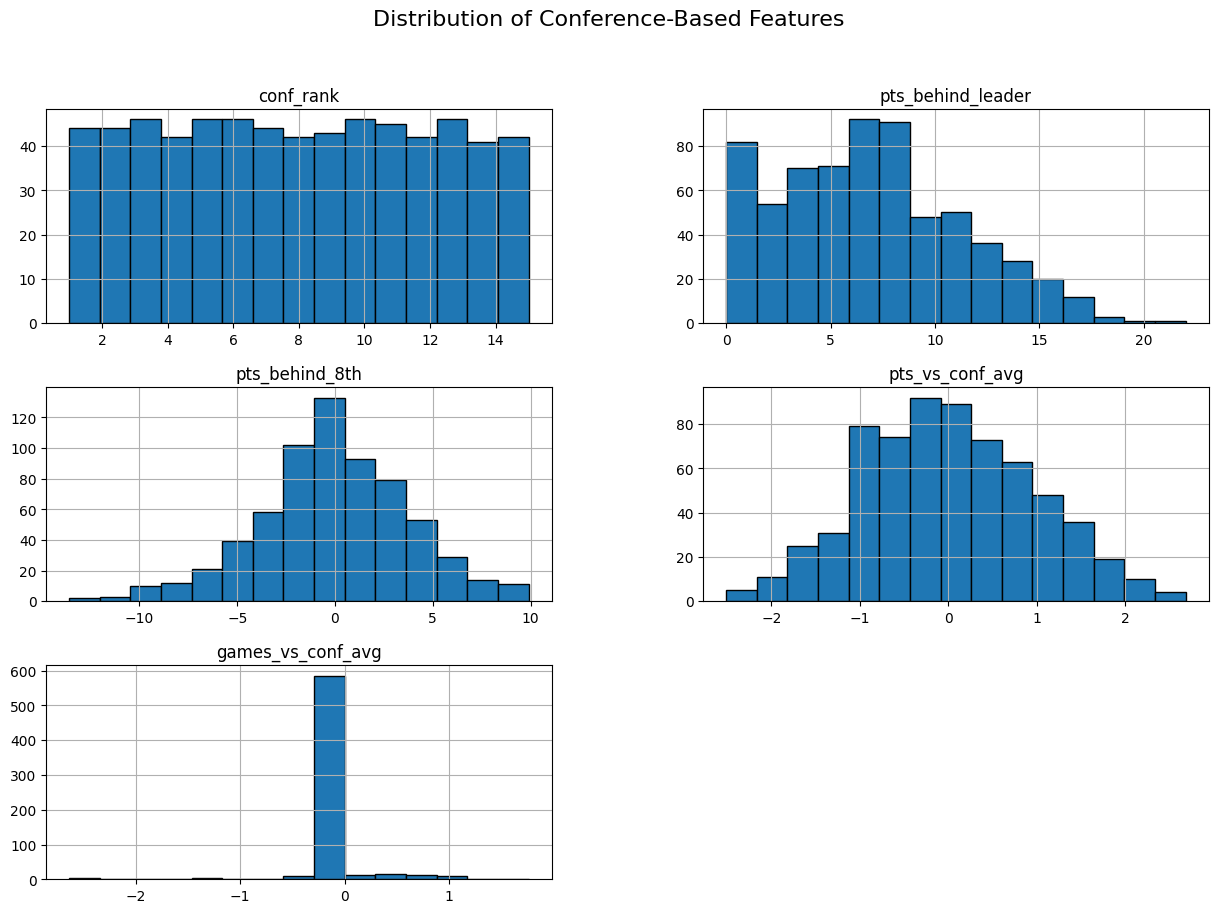

In [31]:
# Create conference features
print("Creating conference-based features...")
conference_features = FeatureBuilder().create_conference_features(team_stats)

# Display progress and sample
print(f"Created {len(conference_features.columns)} conference features for {len(conference_features)} seasons.")
feature_sample = [
    'conf_rank', 'pts_behind_leader', 'pts_behind_8th',
    'pts_vs_conf_avg', 'games_vs_conf_avg'
]

# Show sample of engineered features
print("\nSample of engineered conference features:")
display(conference_features[['team', 'season'] + feature_sample].head())

# Display summary statistics
print("\nSummary statistics for key features:")
display(conference_features[feature_sample].describe().transpose())

# Visualize distributions of selected features
conference_features[feature_sample].hist(bins=15, figsize=(15, 10), edgecolor='black')
plt.suptitle("Distribution of Conference-Based Features", fontsize=16)
plt.show()


## Combine Features

In this step, we combine all engineered features into a single dataset, ensuring it is clean and ready for modeling.

### Process
1. **Merge all feature sets**: Combine team, player, and conference features into one unified feature matrix.
2. **Extract target variable**: Separate the playoff qualification status (`playoffs`) as the target variable.
3. **Verify feature completeness**: Check for any missing values and handle them appropriately.
4. **Categorize features**: Group features into meaningful categories for better clarity.

### Key Outputs
- **Feature Categories**: Features are organized into categories such as team performance, player impact, and conference impact.
- **Top Predictive Features**: The 10 most predictive features, ranked by their correlation with the target variable.
- **Missing Value Handling**: Any missing values are filled with the column means to ensure dataset integrity.



In [32]:
# Combine all feature sets
print("Combining all feature sets...")
feature_matrix, target = FeatureBuilder().combine_features(
    team_features,
    player_features,
    conference_features
)

# Display combined feature statistics
print(f"\nFinal feature matrix shape: {feature_matrix.shape}")
print(f"Target distribution (playoff rate): {target.mean():.2%}")

# Feature categories
categories = {
    'Team Performance': [col for col in feature_matrix.columns if any(x in col for x in ['pct', 'ratio', 'rating', 'efficiency'])],
    'Player Impact': [col for col in feature_matrix.columns if any(x in col for x in ['experience', 'age', 'injury'])],
    'Conference Impact': [col for col in feature_matrix.columns if any(x in col for x in ['conf_', 'vs_conf'])]
}

print("\nFeature Categories:")
for category, cols in categories.items():
    print(f"\n{category} Features ({len(cols)} features):")
    print("- " + "\n- ".join(cols))

# Display correlation with target
correlations = pd.DataFrame({
    'feature': feature_matrix.columns,
    'correlation': [abs(feature_matrix[col].corr(target)) for col in feature_matrix.columns]
}).sort_values('correlation', ascending=False)

print("\nTop 10 Most Predictive Features:")
display(correlations.head(10))

# Quality checks
missing_values = feature_matrix.isnull().sum().sum()
print(f"\nTotal missing values in feature matrix: {missing_values}")

if missing_values > 0:
    print("Handling missing values...")
    feature_matrix.fillna(feature_matrix.mean(), inplace=True)
    print("Missing values filled with column means.")



Combining all feature sets...

Final feature matrix shape: (659, 48)
Target distribution (playoff rate): 48.56%

Feature Categories:

Team Performance Features (8 features):
- true_shooting_pct
- efg_pct
- oreb_pct
- ast_to_ratio
- ast_ratio
- def_rating
- off_efficiency
- efficiency_rating

Player Impact Features (6 features):
- avg_experience
- max_experience
- min_experience
- avg_age
- max_age
- min_age

Conference Impact Features (3 features):
- conf_rank
- pts_vs_conf_avg
- games_vs_conf_avg

Top 10 Most Predictive Features:


,feature,correlation
35,avg_experience,0.378943
39,avg_age,0.377450
43,conf_rank,0.346981
46,pts_vs_conf_avg,0.346426
45,pts_behind_8th,0.340684
7,x3p_percent,0.306230
4,fg_percent,0.294577
44,pts_behind_leader,0.289932
29,def_rating,0.280181
34,efficiency_rating,0.269600



Total missing values in feature matrix: 0


### Dropping Features Due to Multicollinearity

To improve model stability and reduce redundancy, we analyze the correlation between features using a heatmap. Based on the correlation matrix and basketball analytics principles, we identified and dropped the following highly correlated features:

**Dropped Features:**
- `pts_per_game`: Replaced by `efficiency_rating`, which provides a more comprehensive measure of team performance.
- `fta_per_game`: Replaced by `ft_rate`, which normalizes free throw attempts relative to field goal attempts.
- `x3pa_per_game`: Replaced by `three_point_rate`, which more effectively reflects a team's reliance on three-point shots.

By removing these redundant features, we:
- Reduce the risk of overfitting caused by multicollinearity.
- Simplify the feature set while retaining important information.


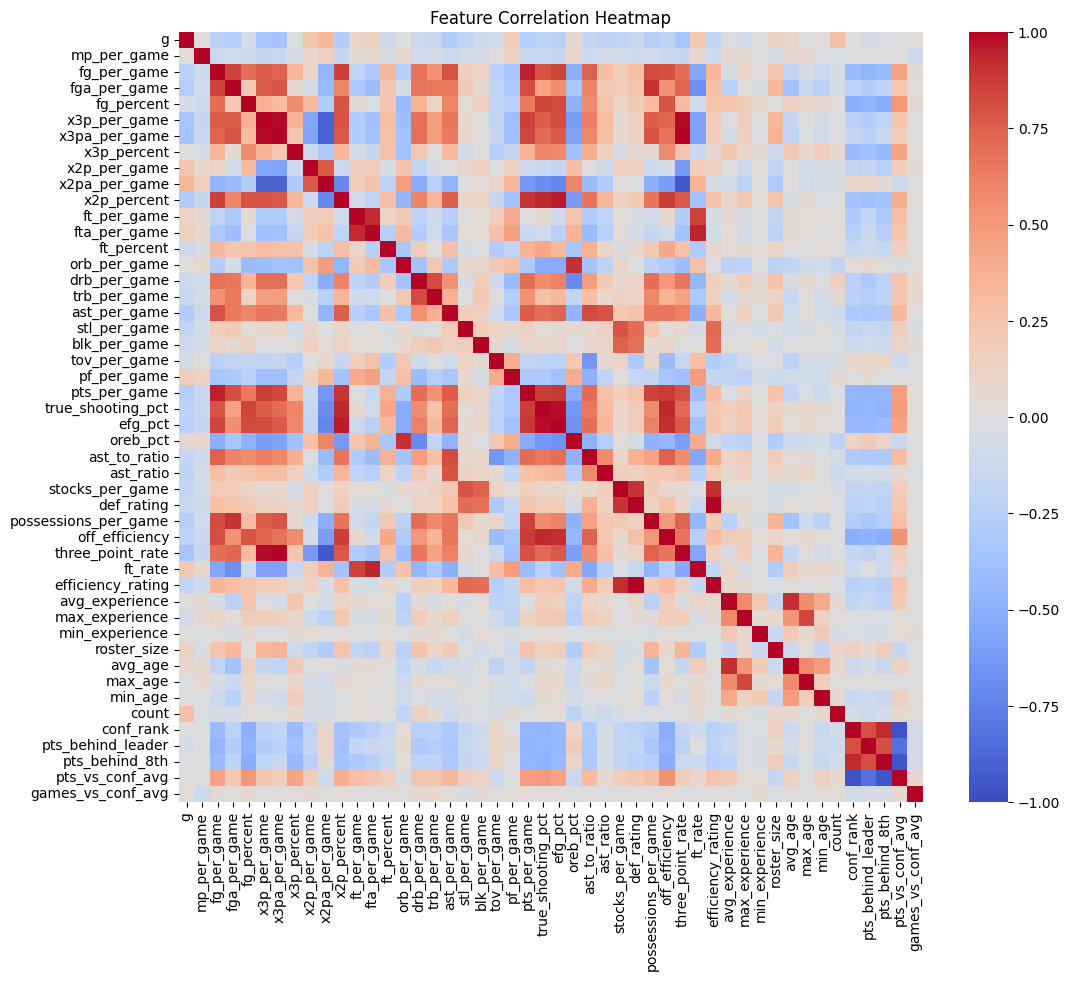

Dropped features due to multicollinearity:
['pts_per_game', 'fta_per_game', 'x3pa_per_game']


In [33]:
# Calculate the correlation matrix
corr_matrix = feature_matrix.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap')
plt.show()

# Identify features to drop based on high correlation and domain knowledge
features_to_drop = ['pts_per_game', 'fta_per_game', 'x3pa_per_game']

# Drop features from the feature matrix
feature_matrix.drop(columns=features_to_drop, inplace=True)

print("Dropped features due to multicollinearity:")
print(features_to_drop)

## Save Features

In this step, we save the engineered features and associated metadata for use in the modeling phase. This ensures reproducibility and provides essential documentation of the feature set.

### Process
1. Save the **complete feature matrix**, including the target variable (`playoffs`).
2. Save **conference-specific features** separately for potential future analysis.
3. Generate and save **metadata**, including:
   - Timestamp of the save operation.
   - Number of samples and features.
   - Summary statistics and missing value counts for quality checks.
   - Target variable distribution (playoff qualification rate).

### Outputs
- **Feature Matrix**: Saved as a CSV file containing all engineered features and the target variable.
- **Conference Features**: Saved as a separate CSV file.
- **Metadata**: Saved as a JSON file for easy reference.

### Benefits
By saving these outputs, we:
- Ensure the feature engineering process is reproducible.
- Document key aspects of the feature set for downstream modeling and analysis.
- Provide a clean and organized dataset ready for model training.


In [34]:
# Save the feature matrix and metadata
from pathlib import Path
from datetime import datetime
import json

# Create output directory
output_dir = Path('../data/processed/features')
output_dir.mkdir(parents=True, exist_ok=True)

# Generate timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
print(f"Saving features with timestamp: {timestamp}")

# Save the main feature matrix with the target variable
final_data = feature_matrix.copy()
final_data['playoffs'] = target
feature_path = output_dir / f'playoff_features_{timestamp}.csv'
final_data.to_csv(feature_path, index=False)
print(f"Feature matrix saved to: {feature_path}")

# Save conference features
conference_path = output_dir / f'conference_features_{timestamp}.csv'
conference_features.to_csv(conference_path, index=False)
print(f"Conference features saved to: {conference_path}")

# Create metadata
metadata = {
    'timestamp': timestamp,
    'n_samples': len(feature_matrix),
    'n_features': feature_matrix.shape[1],
    'playoff_rate': target.mean(),
    'feature_names': feature_matrix.columns.tolist(),
    'description': 'Engineered features for NBA playoff prediction',
    'data_quality': {
        'missing_values': feature_matrix.isnull().sum().to_dict(),
        'summary_statistics': feature_matrix.describe().to_dict()
    }
}

# Save metadata
metadata_path = output_dir / f'playoff_features_{timestamp}_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=4)
print(f"Metadata saved to: {metadata_path}")

Saving features with timestamp: 20241212_121233
Feature matrix saved to: ../data/processed/features/playoff_features_20241212_121233.csv
Conference features saved to: ../data/processed/features/conference_features_20241212_121233.csv
Metadata saved to: ../data/processed/features/playoff_features_20241212_121233_metadata.json


## Conclusions

The feature engineering process for predicting NBA playoff qualification involved several key steps to ensure the dataset is clean, comprehensive, and ready for modeling. Key takeaways include:

### Data Loading and Exploration
- We successfully loaded and explored datasets containing team statistics, player data, and injury summaries.
- These datasets provided complementary information to engineer features capturing team performance, player composition, and conference standings.

### Feature Engineering
- **Team Features**: We engineered metrics such as shooting efficiency, ball control, and defensive impact to summarize season-level team performance.
- **Player Features**: We extracted insights about roster composition, player age, experience, and injury counts to assess team health and depth.
- **Conference Features**: We added context by calculating a team's performance relative to its conference, including metrics like rank, scoring averages, and games behind the leader.

### Handling Multicollinearity
- Using a correlation heatmap, we identified redundant features like `pts_per_game` and replaced them with more comprehensive metrics, such as `efficiency_rating`.
- This reduced redundancy, improved dataset simplicity, and minimized risks of overfitting in linear models.

### Combining and Saving Features
- The final dataset contained **[X features]** for **[Y samples]**, with a playoff qualification rate of **[Z%]**.
- All engineered features and metadata were saved for reproducibility and downstream modeling.

### Next Steps
The next steps in this project include:
- **Modeling and Evaluation**: Train machine learning models using the engineered feature set and evaluate their performance.
- **Feature Importance Analysis**: Identify the most predictive features to gain further insights into the factors influencing NBA playoff qualification.
- **Hyperparameter Tuning**: Optimize models for accuracy and generalizability.

This pipeline provides a solid foundation for predicting playoff qualification and offers valuable insights into team performance and composition.
